# Importation des bibliotheques

In [1]:
!python --version

Python 3.12.12


In [2]:
# !pip install -q tensorflow==2.18.0
!pip install -q git+https://github.com/tensorflow/addons.git
# !pip install ml_dtypes==0.5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)

TensorFlow version: 2.19.0
TensorFlow Addons version: 0.23.0-dev


/usr/local/lib/python3.12/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.19.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

# Telechargement et preparation de la dataset

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

  # Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [40]:
!kaggle datasets download -d shuvokumarbasakbd/brain-tumors-mri-crystal-clean-colorized-mri-data

Dataset URL: https://www.kaggle.com/datasets/shuvokumarbasakbd/brain-tumors-mri-crystal-clean-colorized-mri-data
License(s): MIT
brain-tumors-mri-crystal-clean-colorized-mri-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
from zipfile import ZipFile
file_name = "/content/brain-tumors-mri-crystal-clean-colorized-mri-data.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

In [43]:
import os
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# Define the dataset paths in the new format
normal = [
    '/content/dataset/test/Normal',
    '/content/dataset/train/Normal',
    '/content/dataset/validation/Normal'
]

glioma_tumor = [
    '/content/dataset/test/glioma_tumor',
    '/content/dataset/train/glioma_tumor',
    '/content/dataset/validation/glioma_tumor'
]

meningioma_tumor = [
    '/content/dataset/test/meningioma_tumor',
    '/content/dataset/train/meningioma_tumor',
    '/content/dataset/validation/meningioma_tumor'
]

pituitary_tumor = [
    '/content/dataset/test/pituitary_tumor',
    '/content/dataset/train/pituitary_tumor',
    '/content/dataset/validation/pituitary_tumor'
]

In [44]:
# Function to load file paths and labels
def load_data(paths, label):
    filepaths = []
    labels = []
    for path in paths:
        # Check if directory exists
        if os.path.exists(path):
            for file in tqdm(os.listdir(path), desc=f"Loading {os.path.basename(path)}"):
                full_path = os.path.join(path, file)
                filepaths.append(full_path)
                labels.append(label)
        else:
            print(f"Warning: Directory {path} does not exist")
    return filepaths, labels

# Load the data
normal_files, normal_labels = load_data(normal, 0)
glioma_files, glioma_labels = load_data(glioma_tumor, 1)
meningioma_files, meningioma_labels = load_data(meningioma_tumor, 2)
pituitary_files, pituitary_labels = load_data(pituitary_tumor, 3)

# Combine all data
filepaths = normal_files + glioma_files + meningioma_files + pituitary_files
labels = normal_labels + glioma_labels + meningioma_labels + pituitary_labels

Loading Normal:   0%|          | 0/200 [00:00<?, ?it/s]

Loading Normal:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Normal:   0%|          | 0/200 [00:00<?, ?it/s]

Loading glioma_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

Loading glioma_tumor:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading glioma_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

Loading meningioma_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

Loading meningioma_tumor:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading meningioma_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

Loading pituitary_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

Loading pituitary_tumor:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading pituitary_tumor:   0%|          | 0/200 [00:00<?, ?it/s]

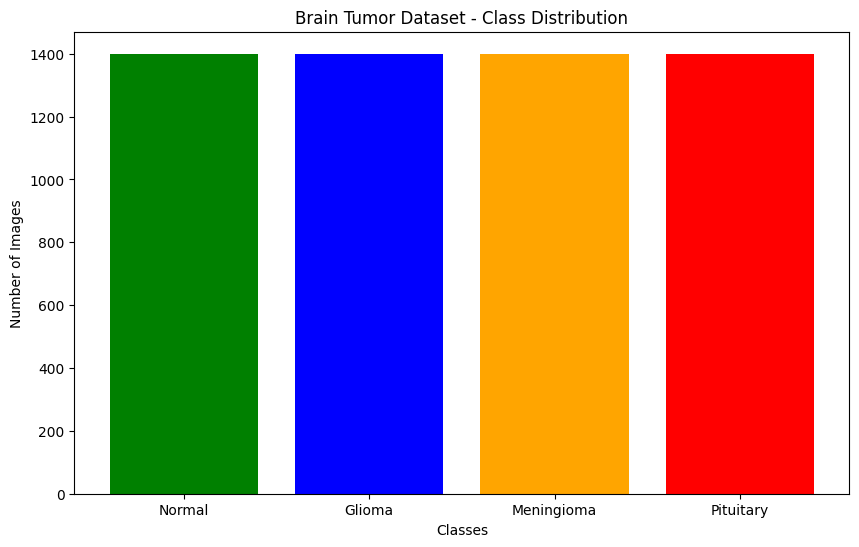

Number of Normal images: 1400
Number of Glioma Tumor images: 1400
Number of Meningioma Tumor images: 1400
Number of Pituitary Tumor images: 1400
Total number of images: 5600


In [45]:
# Count the number of images in each class
normal_count = len(normal_files)
glioma_count = len(glioma_files)
meningioma_count = len(meningioma_files)
pituitary_count = len(pituitary_files)

# Create a histogram
classes = ['Normal', 'Glioma', 'Meningioma', 'Pituitary']
counts = [normal_count, glioma_count, meningioma_count, pituitary_count]
colors = ['green', 'blue', 'orange', 'red']

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color=colors)
plt.title('Brain Tumor Dataset - Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

# Display the number of images in each class
print(f"Number of Normal images: {normal_count}")
print(f"Number of Glioma Tumor images: {glioma_count}")
print(f"Number of Meningioma Tumor images: {meningioma_count}")
print(f"Number of Pituitary Tumor images: {pituitary_count}")
print(f"Total number of images: {len(filepaths)}")


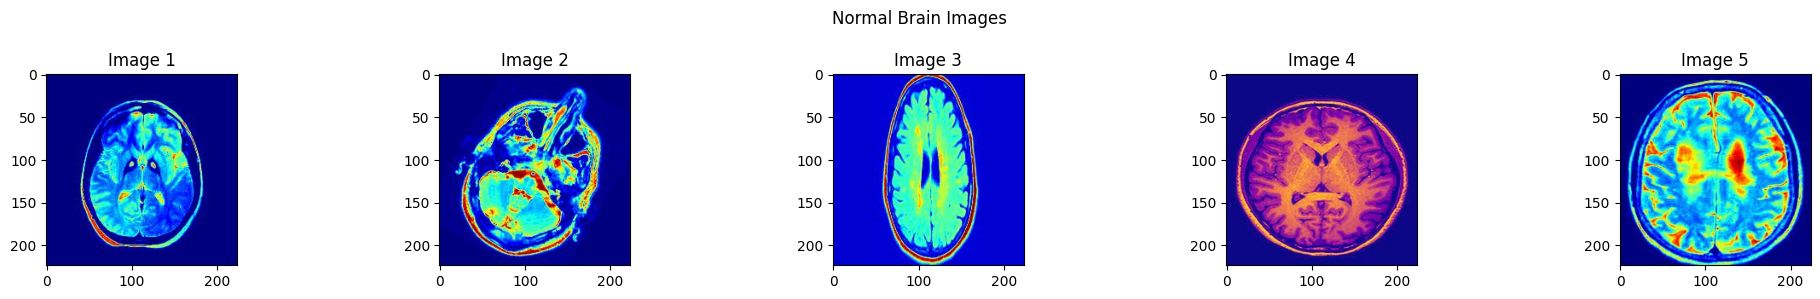

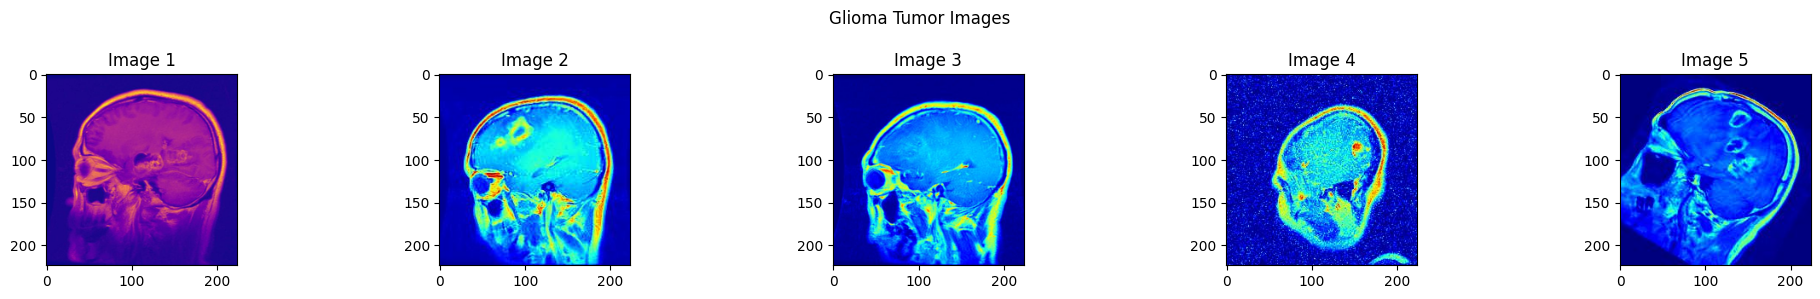

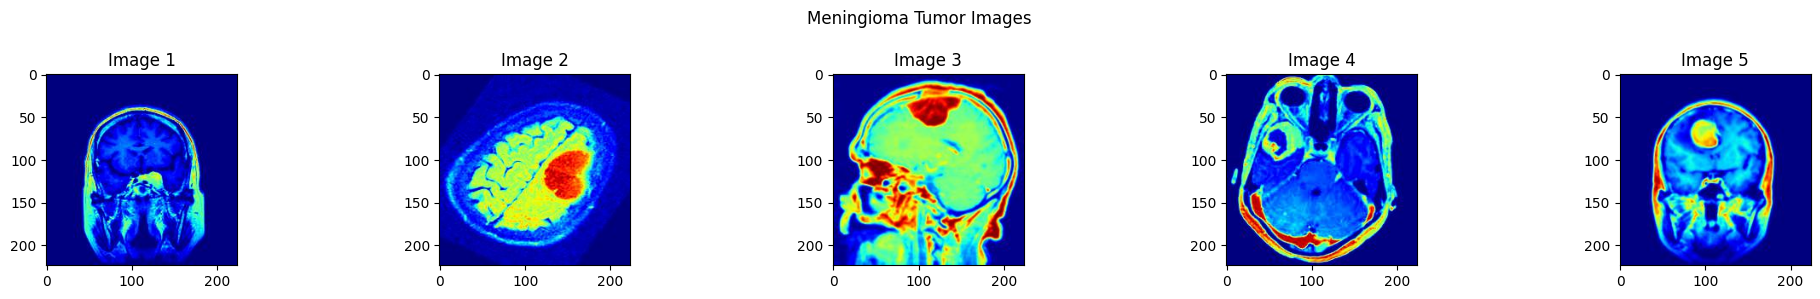

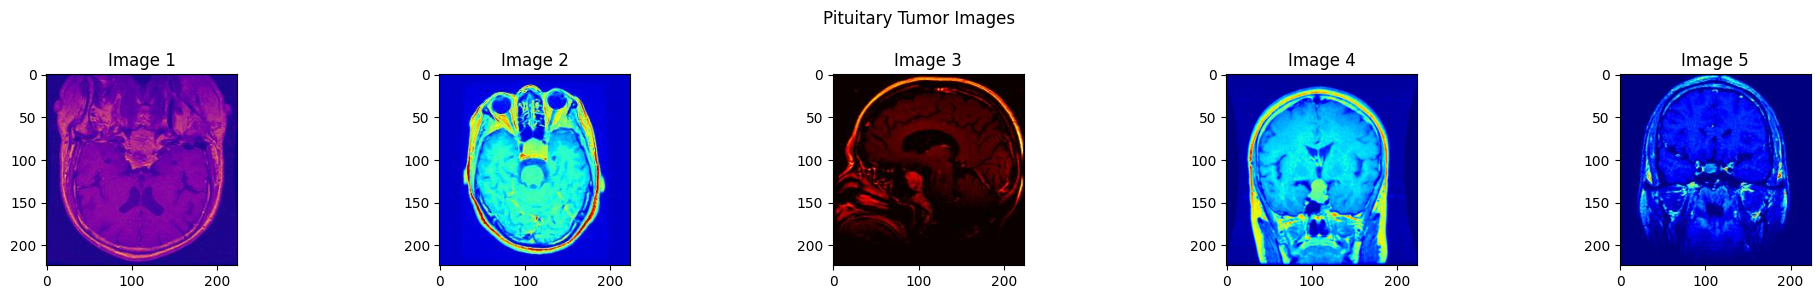

In [46]:
def display_images(filepaths, title, num_images=5, img_size=(224, 224)):
    plt.figure(figsize=(20, 3))
    plt.suptitle(title)

    for i in range(num_images):
        img_path = random.choice(filepaths)
        img = Image.open(img_path).resize(img_size)  # Redimensionner l'image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')  # Affiche l'image en niveaux de gris
        plt.axis('on')
        plt.title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Display images from all classes
display_images(normal_files, 'Normal Brain Images', img_size=(224, 224))
display_images(glioma_files, 'Glioma Tumor Images', img_size=(224, 224))
display_images(meningioma_files, 'Meningioma Tumor Images', img_size=(224, 224))
display_images(pituitary_files, 'Pituitary Tumor Images', img_size=(224, 224))

# Splitting de la dataset

In [47]:
train_files, test_files, train_labels, test_labels = train_test_split(filepaths, labels, test_size=0.2, random_state=42)

In [48]:
print(len(train_files))
print(len(test_files))

4480
1120


In [49]:
# Split the training data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=42
)

In [14]:
print(len(train_files))
print(len(test_files))
print(len(val_files))

4032
1120
448


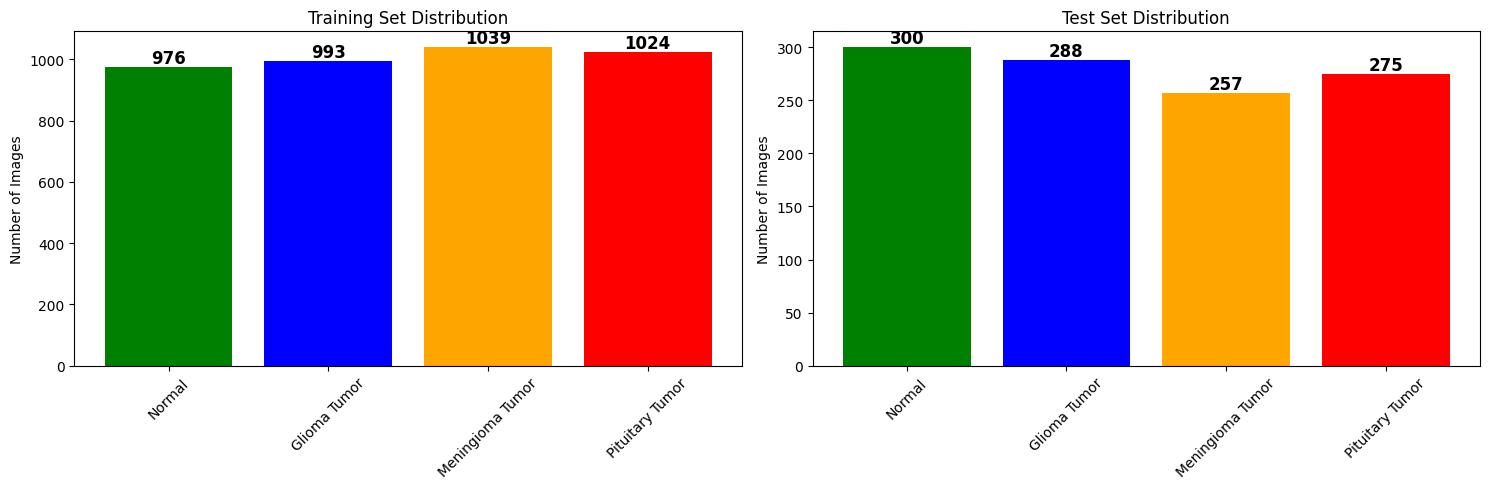

Training set counts:
Normal: 976
Glioma Tumor: 993
Meningioma Tumor: 1039
Pituitary Tumor: 1024

Test set counts:
Normal: 300
Glioma Tumor: 288
Meningioma Tumor: 257
Pituitary Tumor: 275


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to NumPy array for easier processing
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Count the occurrences of each class
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Define class names
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Training set histogram
bars_train = ax[0].bar(class_names, train_counts, color=['green', 'blue', 'orange', 'red'])
ax[0].set_title("Training Set Distribution")
ax[0].set_ylabel("Number of Images")
ax[0].tick_params(axis='x', rotation=45)

# Test set histogram
bars_test = ax[1].bar(class_names, test_counts, color=['green', 'blue', 'orange', 'red'])
ax[1].set_title("Test Set Distribution")
ax[1].set_ylabel("Number of Images")
ax[1].tick_params(axis='x', rotation=45)

# Add labels on top of the bars
for bar in bars_train:
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

for bar in bars_test:
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the counts for verification
print("Training set counts:")
for i, count in enumerate(train_counts):
    print(f"{class_names[i]}: {count}")

print("\nTest set counts:")
for i, count in enumerate(test_counts):
    print(f"{class_names[i]}: {count}")

# Test de quelques techniques d'augmentation

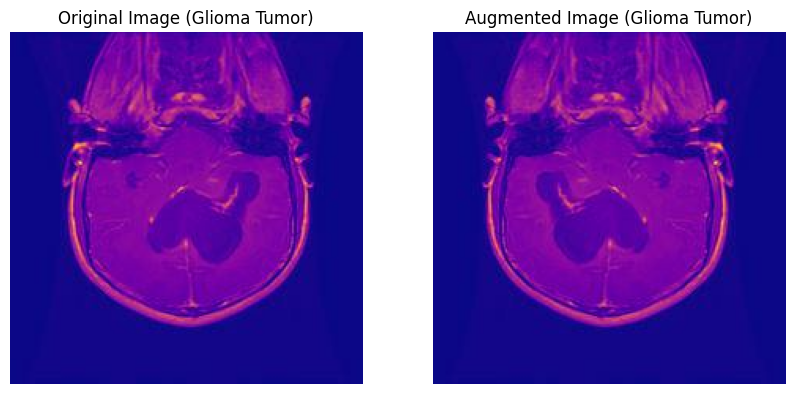

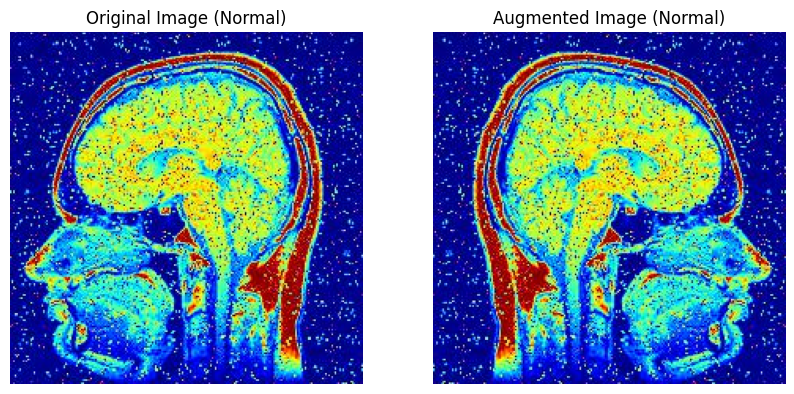

In [65]:
# Flip horizontal for Glioma Tumor
image_path1 = '/content/dataset/train/glioma_tumor/G_105_VF__8.jpg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
left_right1 = tf.image.random_flip_left_right(image1)

# Flip horizontal for Normal
image_path2 = '/content/dataset/train/Normal/N_101_SP__7.jpg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
left_right2 = tf.image.random_flip_left_right(image2)

# Display Glioma Tumor images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image (Glioma Tumor)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(left_right1.numpy().astype(int))  # Display flipped image
plt.title('Augmented Image (Glioma Tumor)')
plt.axis('off')

plt.show()

# Display Normal images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image (Normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(left_right2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image (Normal)')
plt.axis('off')

plt.show()

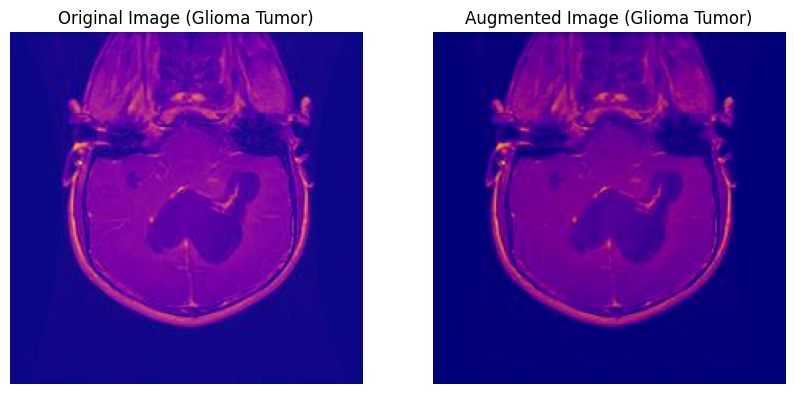

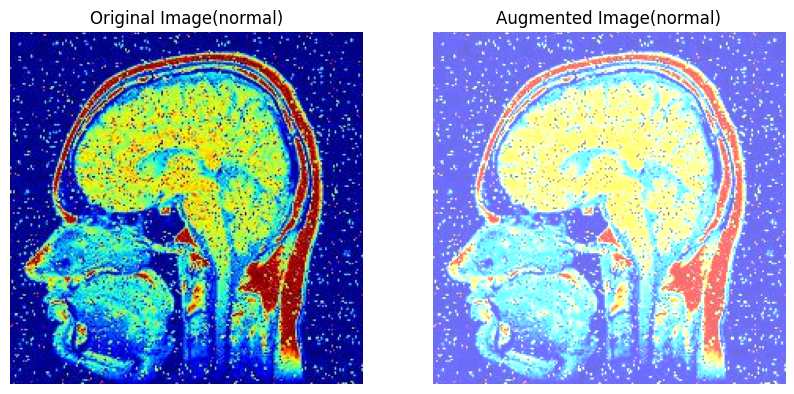

In [67]:
#Modification de la luminosité
image_path1 = '/content/dataset/train/glioma_tumor/G_105_VF__8.jpg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
bright1 = tf.image.random_brightness(image1, max_delta=0.2)
image_path2 = '/content/dataset/train/Normal/N_101_SP__7.jpg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
bright2 = tf.image.random_brightness(image2, max_delta=0.2)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image (Glioma Tumor)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bright1.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image (Glioma Tumor)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bright2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

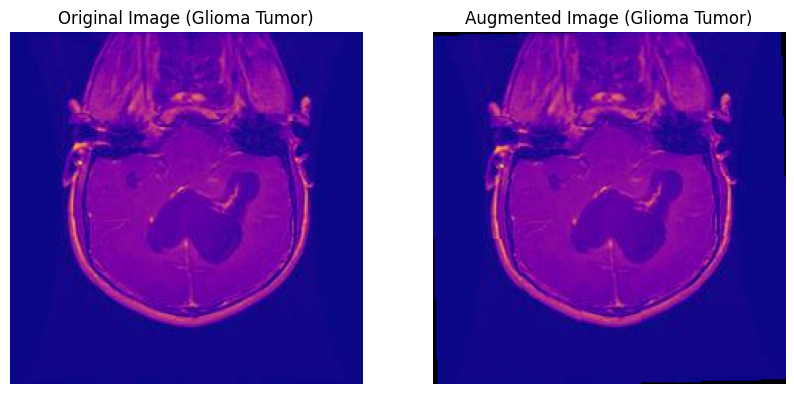

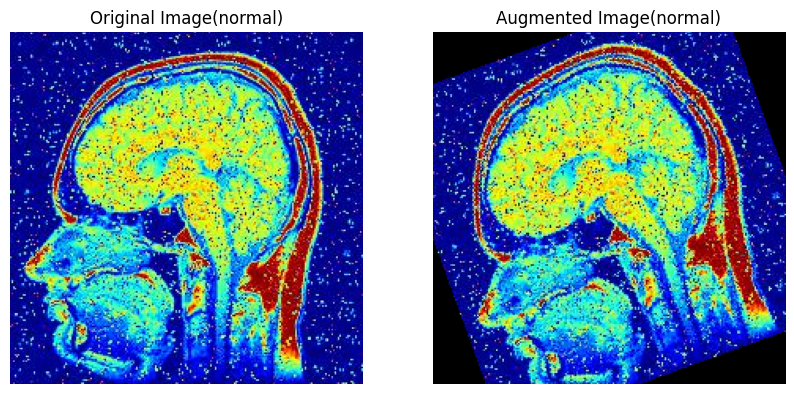

In [71]:

#rotation
image_path1 = '/content/dataset/train/glioma_tumor/G_105_VF__8.jpg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)  # Rotation entre -15° et 15° (en radians)
rot1 = tfa.image.rotate(image1, angles)
image_path2 = '/content/dataset/train/Normal/N_101_SP__7.jpg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)  # Rotation entre -10° et 10° (en radians)
rot2 = tfa.image.rotate(image2, angles)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image (Glioma Tumor)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rot1.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image (Glioma Tumor)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rot2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

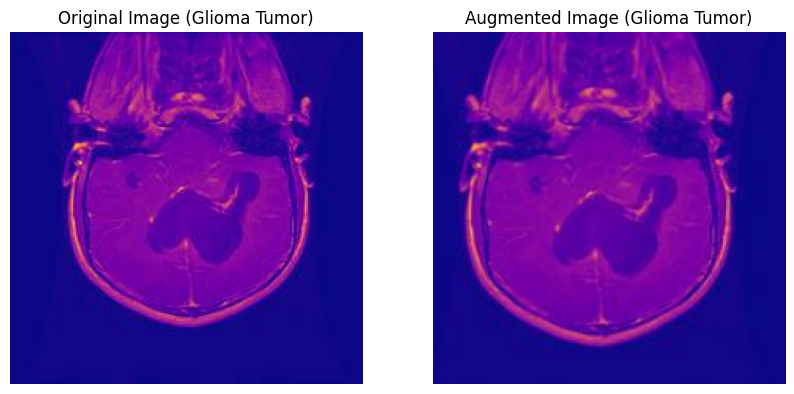

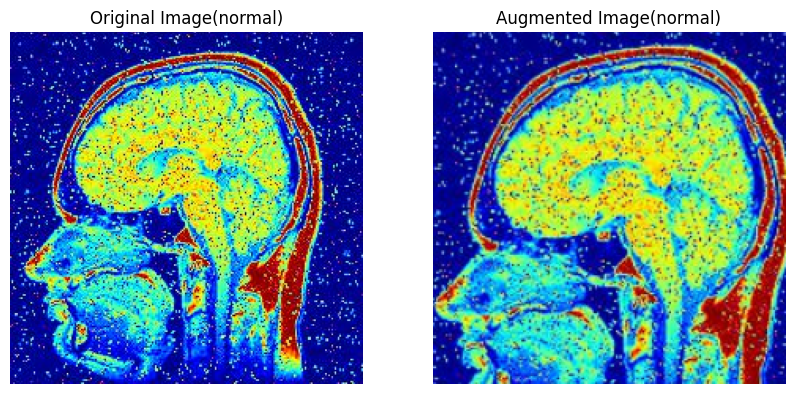

In [73]:
#zoom
image_path1 = '/content/dataset/train/glioma_tumor/G_105_VF__8.jpg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)
original_shape = tf.shape(image1)
new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
image11 = tf.image.resize(image1, new_shape)
image12 = tf.image.random_crop(image11, original_shape)
image_path2 = '/content/dataset/train/Normal/N_101_SP__7.jpg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.4)
original_shape = tf.shape(image2)
new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
image22 = tf.image.resize(image2, new_shape)
image13 = tf.image.random_crop(image22, original_shape)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image (Glioma Tumor)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image12.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image (Glioma Tumor)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image13.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

# Augmentation de la dataset

In [51]:
def create_dataset(filepaths, labels, batch_size=32, augment=False):
    def load_and_preprocess_image(filepath, label):
        try:
            image = tf.io.read_file(filepath)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [224, 224])
            image = image / 255.0  # Normalisation
            return image, label
        except tf.errors.InvalidArgumentError:
            # Handle cases where image decoding fails
            print(f"Skipping invalid image file: {filepath.numpy()}")
            return tf.constant([], dtype=tf.float32), tf.constant([], dtype=tf.int32) # Return empty tensors

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda image, label: tf.size(image) > 0) # Filter out empty tensors

    if augment:
        def augment_image(image, label):
            angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)
            image = tfa.image.rotate(image, angles)
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            # Zoom (20% zoom in)
            zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)
            original_shape = tf.shape(image)
            new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
            image = tf.image.resize(image, new_shape)
            image = tf.image.random_crop(image, original_shape)
            image = tf.clip_by_value(image, 0.0, 1.0)
            # Return the image and label, regardless of augmentation
            return image, label
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Créer les datasets
train_dataset = create_dataset(train_files, train_labels, augment=True)
test_dataset = create_dataset(test_files, test_labels)
val_dataset = create_dataset(val_files, val_labels)

# Affichage de quelques images apres augmentation

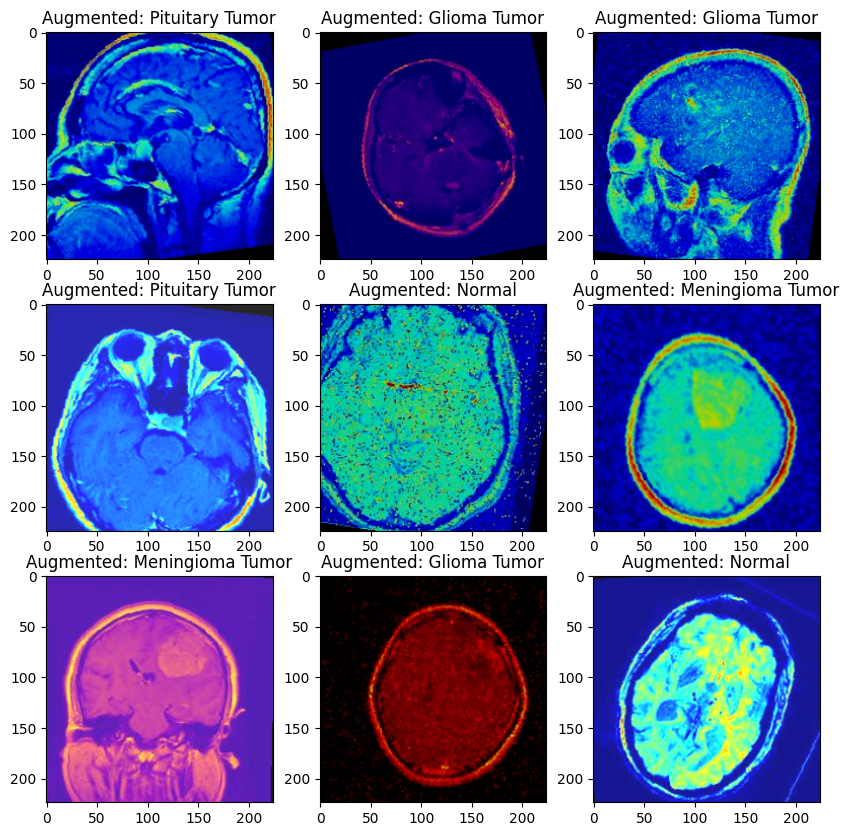

In [ ]:
import matplotlib.pyplot as plt

# Dictionnaire de correspondance des labels pour les deux classes
label_dict = {0: "Normal", 1: "Glioma Tumor", 2: "Meningioma Tumor", 3: "Pituitary Tumor"}

# Prendre un batch d'images du dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Afficher jusqu'à 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Augmented: {label_dict[labels[i].numpy()]}")
        plt.axis("on")
    plt.show()

# Preparation du modele (VGG19 avec imagenet)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger un modèle pré-entraîné (VGG19)
base_model = VGG19(include_top=False, input_shape=(224,224,3), weights='imagenet')

# Dégeler partiellement le modèle (ex : les 10 dernières couches)
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Changé à 4 pour vos 4 classes

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
for layer in model.layers:
   print(layer, layer.trainable== True)

## Entrainement du modele avec callbacks

**Exercice** : Écrivez un code TensorFlow/Keras pour entraîner un modèle CNN (VGG19) sur le jeu de données d’images (train_files et val_dataset) en utilisant des callbacks afin de :

-Arrêter automatiquement l’entraînement lorsque la performance sur les données de validation cesse de s’améliorer.

-Sauvegarder uniquement la version du modèle ayant obtenu la meilleure performance sur la validation.

Instructions :

- Utilisez EarlyStopping pour surveiller la perte de validation (val_loss) et restaurer les meilleurs poids.

- Utilisez ModelCheckpoint pour sauvegarder le meilleur modèle dans un fichier nommé 'best_modelVGG19.keras'.

- Entraînez le modèle sur un maximum de 50 époques avec les callbacks activés.

In [ ]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=3,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_modelVGG19.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',            # Surveiller la précision de validation
        save_best_only=True,               # Sauvegarder seulement le meilleur modèle
        mode='max',                        # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]

# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_modelVGG19.keras")

Epoch 1/50
    126/Unknown 68s 336ms/step - accuracy: 0.3225 - loss: 1.3696

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.52902, saving model to best_modelVGG19.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 77s 405ms/step - accuracy: 0.3229 - loss: 1.3690 - val_accuracy: 0.5290 - val_loss: 1.1473
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5181 - loss: 1.1104
Epoch 2: val_accuracy improved from 0.52902 to 0.71652, saving model to best_modelVGG19.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 387ms/step - accuracy: 0.5183 - loss: 1.1100 - val_accuracy: 0.7165 - val_loss: 0.7706
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6639 - loss: 0.8561
Epoch 3: val_accuracy improved from 0.71652 to 0.75893, saving model to best_modelVGG19.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 48s 381ms/step - accuracy: 0.6641 - loss: 0.8556 - val_accuracy: 0.7589 - val_loss: 0.6437
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7703 - loss: 0.6329
Epoch 4: val_accuracy improved from 0.75893 to 0.83036, saving model to best_modelVGG19.keras
12

## Chargement du modele et metrics

In [ ]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

model = load_model('best_modelVGG19.keras')

# Afficher le résumé pour vérifier le chargement
# model.summary()

print("Modèle rechargé avec succès!")

Modèle rechargé avec succès!


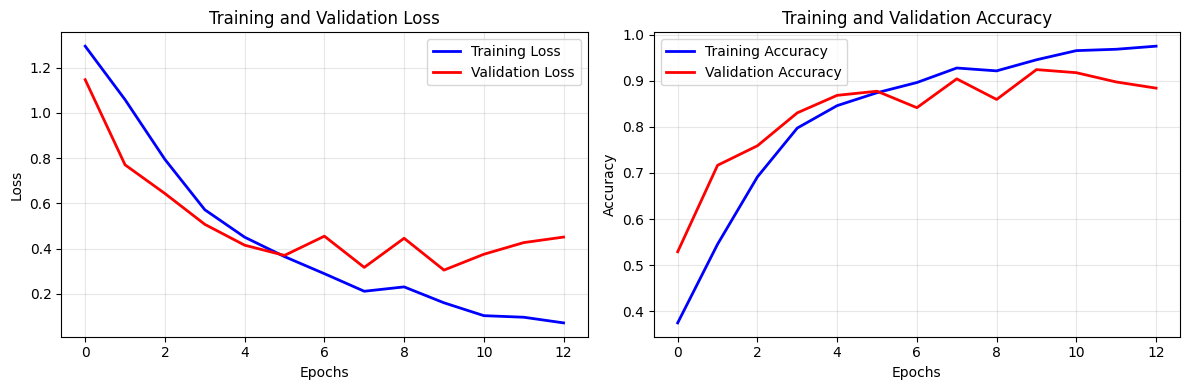

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Afficher le rapport de classification avec 4 chiffres après la virgule
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les vraies labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Si les labels sont en one-hot encoding, les convertir en classes
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Afficher le rapport de classification avec 4 chiffres après la virgule
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(y_true, y_pred_classes,
                          target_names=class_names,
                          digits=4))


# Calculer et afficher les métriques globales
print("=" * 70)
print("MÉTRIQUES GLOBALES")
print("=" * 70)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step
RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

          Normal     0.9724    0.9400    0.9559       300
    Glioma Tumor     0.8881    0.9097    0.8988       288
Meningioma Tumor     0.8593    0.8794    0.8692       257
 Pituitary Tumor     0.9449    0.9345    0.9397       275

        accuracy                         0.9170      1120
       macro avg     0.9162    0.9159    0.9159      1120
    weighted avg     0.9180    0.9170    0.9174      1120

MÉTRIQUES GLOBALES
Accuracy:  0.9170
Precision: 0.9180
Recall:    0.9170
F1-Score:  0.9174


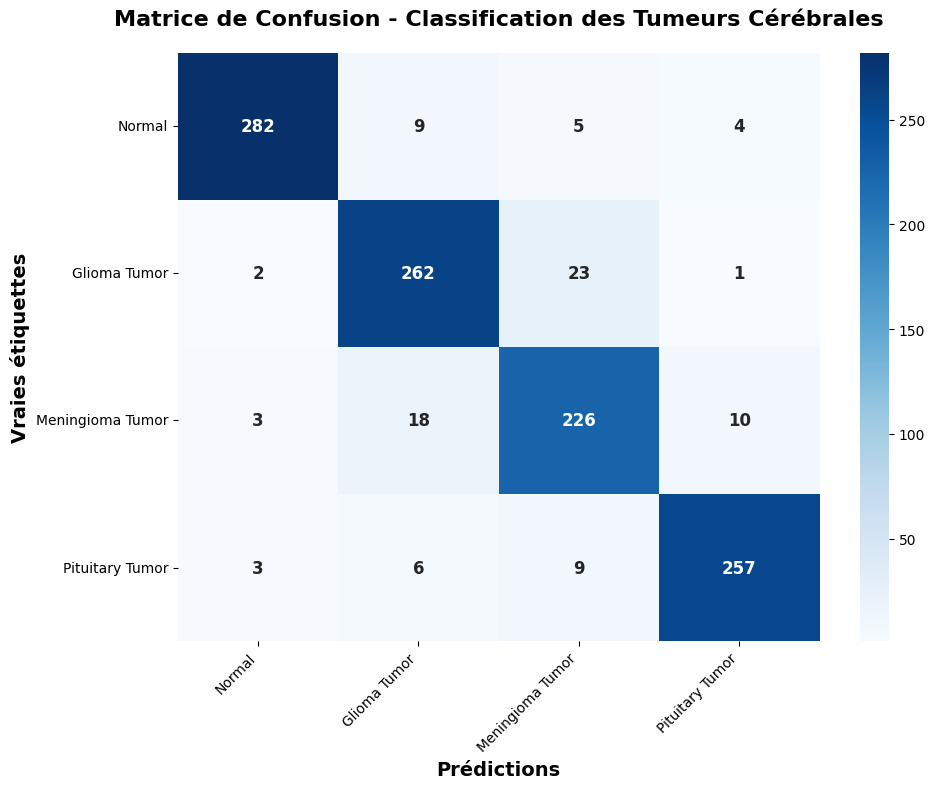

In [ ]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Visualisation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matrice de Confusion - Classification des Tumeurs Cérébrales',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Vraies étiquettes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Préparation du modéle ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger un modèle pré-entraîné (ResNet50)
base_model = ResNet50(include_top=False, input_shape=(224,224,3), weights='imagenet')

# Dégeler partiellement le modèle (ex : les 10 dernières couches)
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 4,991,236 (19.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [ ]:
for layer in model.layers:
   print(layer, layer.trainable== True)

In [ ]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=5,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_modelResNet50.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',               # Surveiller la précision de validation
        save_best_only=True,                  # Sauvegarder seulement le meilleur modèle
        mode='max',                           # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]
# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_modelResNet50.keras")

Epoch 1/50
    126/Unknown 12s 99ms/step - accuracy: 0.5933 - loss: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.35268, saving model to best_modelResNet50.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.5934 - loss: 0.9556 - val_accuracy: 0.3527 - val_loss: 1.6610
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6208 - loss: 0.8916
Epoch 2: val_accuracy improved from 0.35268 to 0.45536, saving model to best_modelResNet50.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.6209 - loss: 0.8915 - val_accuracy: 0.4554 - val_loss: 1.3657
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6508 - loss: 0.8400
Epoch 3: val_accuracy did not improve from 0.45536
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.6508 - loss: 0.8400 - val_accuracy: 0.3103 - val_loss: 2.3679
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6618 - loss: 0.8290
Epoch 4: val_accuracy improved from 0.45536 to 0.49330, saving

In [ ]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

model = load_model('best_modelResNet50.keras')

# Afficher le résumé pour vérifier le chargement
# model.summary()

print("Modèle rechargé avec succès!")

Modèle rechargé avec succès!


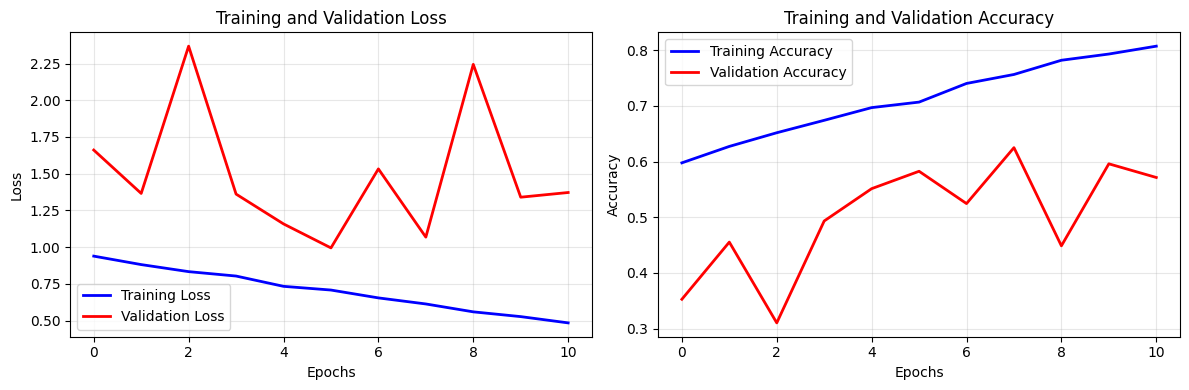

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Afficher le rapport de classification avec 4 chiffres après la virgule
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les vraies labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Si les labels sont en one-hot encoding, les convertir en classes
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Afficher le rapport de classification avec 4 chiffres après la virgule
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(y_true, y_pred_classes,
                          target_names=class_names,
                          digits=4))


# Calculer et afficher les métriques globales
print("=" * 70)
print("MÉTRIQUES GLOBALES")
print("=" * 70)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step
RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

          Normal     0.6844    0.8167    0.7447       300
    Glioma Tumor     0.5341    0.7882    0.6367       288
Meningioma Tumor     0.5472    0.1128    0.1871       257
 Pituitary Tumor     0.7676    0.7927    0.7800       275

        accuracy                         0.6420      1120
       macro avg     0.6333    0.6276    0.5871      1120
    weighted avg     0.6347    0.6420    0.5976      1120

MÉTRIQUES GLOBALES
Accuracy:  0.6420
Precision: 0.6347
Recall:    0.6420
F1-Score:  0.5976


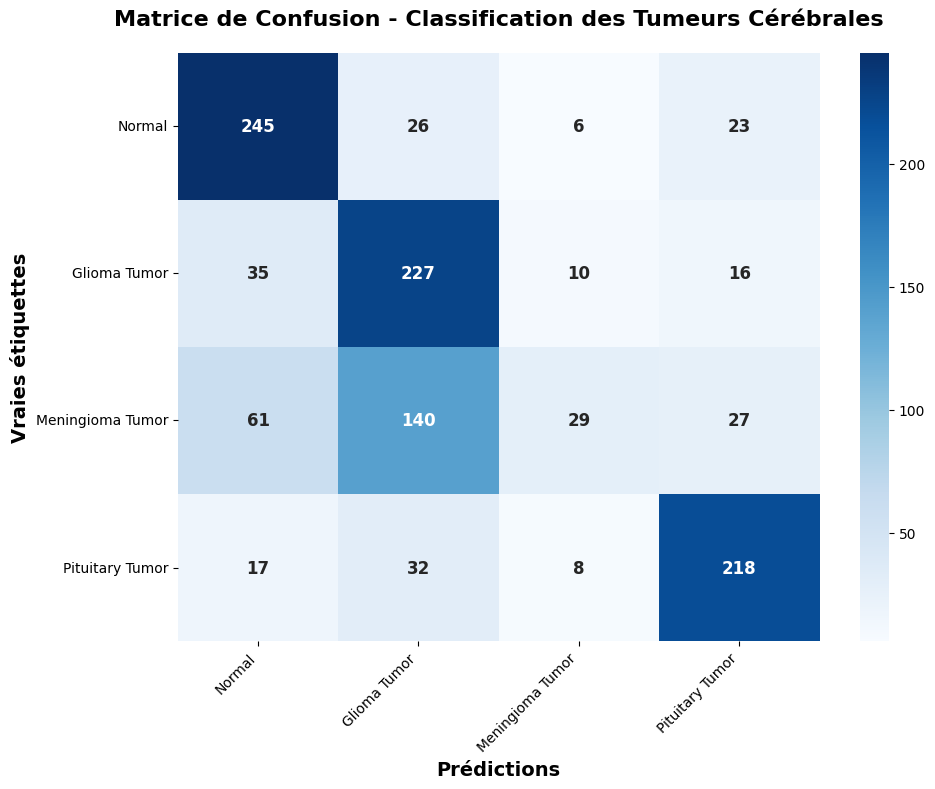

In [ ]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Visualisation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matrice de Confusion - Classification des Tumeurs Cérébrales',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Vraies étiquettes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Préparation du modéle ResNet152

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger un modèle pré-entraîné (ResNet50)
base_model = ResNet152(include_top=False, input_shape=(224,224,3), weights='imagenet')

# Dégeler partiellement le modèle (ex : les 10 dernières couches)
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

In [ ]:
for layer in model.layers:
   print(layer, layer.trainable== True)

In [ ]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=3,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_modelResNet152.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',               # Surveiller la précision de validation
        save_best_only=True,                  # Sauvegarder seulement le meilleur modèle
        mode='max',                           # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]
# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_modelResNet50.keras")

Epoch 1/50
    126/Unknown 30s 237ms/step - accuracy: 0.6686 - loss: 0.8243
Epoch 1: val_accuracy improved from -inf to 0.52455, saving model to best_modelResNet152.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.6686 - loss: 0.8242 - val_accuracy: 0.5246 - val_loss: 1.2993
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6807 - loss: 0.7865
Epoch 2: val_accuracy did not improve from 0.52455
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.6808 - loss: 0.7864 - val_accuracy: 0.4955 - val_loss: 1.5757
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7024 - loss: 0.7152
Epoch 3: val_accuracy improved from 0.52455 to 0.59598, saving model to best_modelResNet152.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.7026 - loss: 0.7150 - val_accuracy: 0.5960 - val_loss: 1.0644
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7512 - loss: 0.6402
Epoch 4: val_accuracy did not improve from 0.59598
126/1

In [ ]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=5,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_modelResNet152.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',               # Surveiller la précision de validation
        save_best_only=True,                  # Sauvegarder seulement le meilleur modèle
        mode='max',                           # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]
# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_modelResNet152.keras")

Epoch 1/50
    126/Unknown 30s 239ms/step - accuracy: 0.8249 - loss: 0.4445
Epoch 1: val_accuracy improved from -inf to 0.61830, saving model to best_modelResNet152.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.8250 - loss: 0.4443 - val_accuracy: 0.6183 - val_loss: 1.2803
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8576 - loss: 0.3794
Epoch 2: val_accuracy did not improve from 0.61830
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.8577 - loss: 0.3792 - val_accuracy: 0.5402 - val_loss: 1.6006
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8816 - loss: 0.3367
Epoch 3: val_accuracy did not improve from 0.61830
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - accuracy: 0.8816 - loss: 0.3366 - val_accuracy: 0.5759 - val_loss: 1.5000
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8781 - loss: 0.3154
Epoch 4: val_accuracy did not improve from 0.61830
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accura

In [ ]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

model = load_model('best_modelResNet152.keras')

# Afficher le résumé pour vérifier le chargement
# model.summary()

print("Modèle rechargé avec succès!")

Modèle rechargé avec succès!


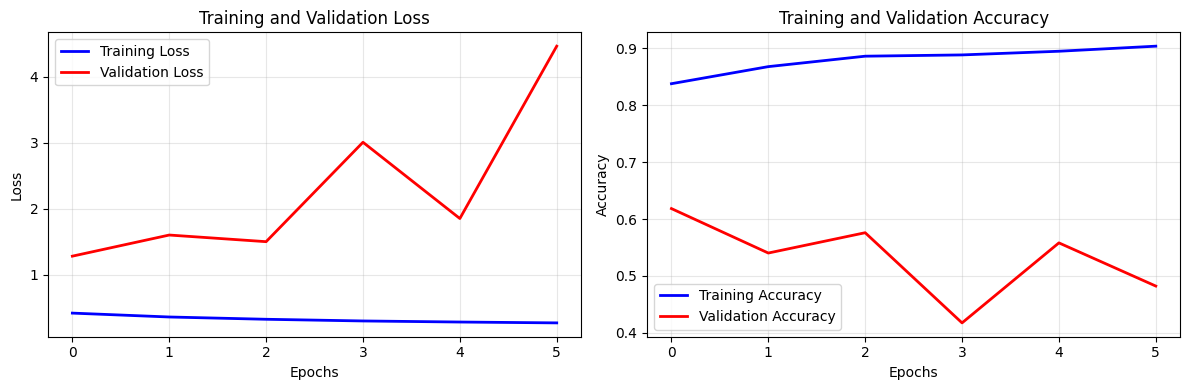

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Afficher le rapport de classification avec 4 chiffres après la virgule
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les vraies labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Si les labels sont en one-hot encoding, les convertir en classes
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Afficher le rapport de classification avec 4 chiffres après la virgule
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(y_true, y_pred_classes,
                          target_names=class_names,
                          digits=4))


# Calculer et afficher les métriques globales
print("=" * 70)
print("MÉTRIQUES GLOBALES")
print("=" * 70)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step
RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

          Normal     0.6448    0.7200    0.6803       300
    Glioma Tumor     0.5610    0.7188    0.6301       288
Meningioma Tumor     0.4714    0.2568    0.3325       257
 Pituitary Tumor     0.7355    0.7382    0.7368       275

        accuracy                         0.6179      1120
       macro avg     0.6032    0.6084    0.5949      1120
    weighted avg     0.6057    0.6179    0.6015      1120

MÉTRIQUES GLOBALES
Accuracy:  0.6179
Precision: 0.6057
Recall:    0.6179
F1-Score:  0.6015


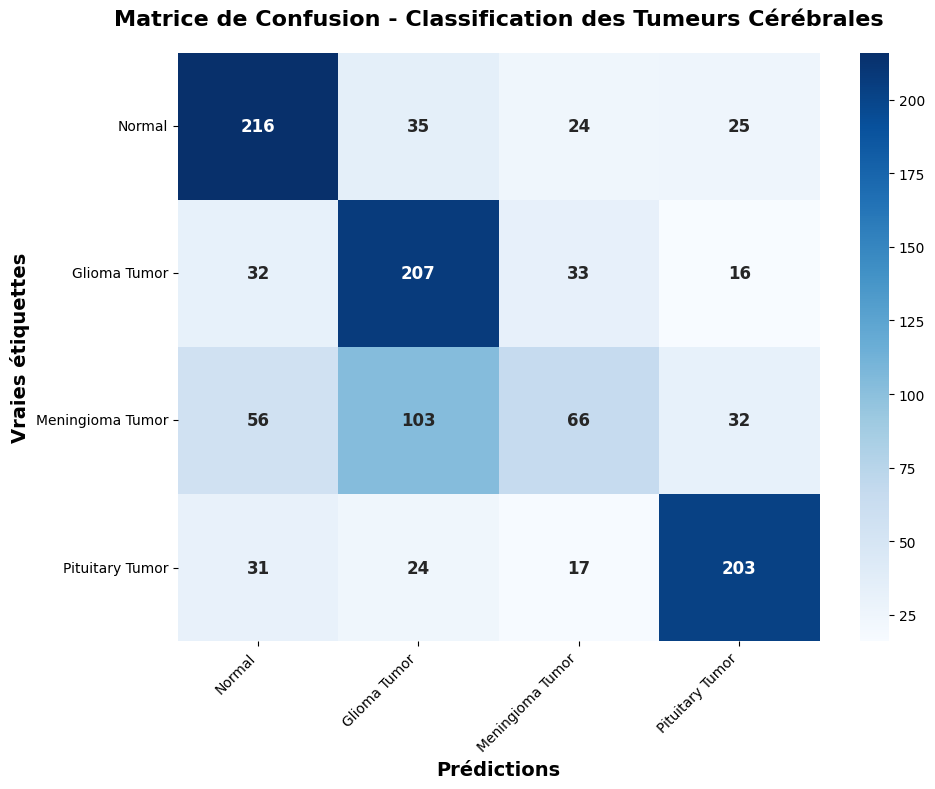

In [ ]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Visualisation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matrice de Confusion - Classification des Tumeurs Cérébrales',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Vraies étiquettes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Préparation du modéle EfficientNetB0

In [52]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input  # IMPORTANT !
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Charger EfficientNetB0
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Dégeler davantage de couches (30 dernières)
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)  # Plus de neurones
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Créer le modèle
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler avec learning rate plus élevé
model.compile(
    optimizer=Adam(learning_rate=1e-3),  # Plus élevé
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
for layer in model.layers:
   print(layer, layer.trainable== True)

In [53]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=5,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_EfficientNetB0.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',               # Surveiller la précision de validation
        save_best_only=True,                  # Sauvegarder seulement le meilleur modèle
        mode='max',                           # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]
# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_EfficientNetB0.keras")

Epoch 1/50
    126/Unknown 51s 140ms/step - accuracy: 0.2691 - loss: 2.1191
Epoch 1: val_accuracy improved from -inf to 0.27679, saving model to best_EfficientNetB0.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 237ms/step - accuracy: 0.2690 - loss: 2.1172 - val_accuracy: 0.2768 - val_loss: 1.3855
Epoch 2/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2539 - loss: 1.4748
Epoch 2: val_accuracy did not improve from 0.27679
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.2538 - loss: 1.4745 - val_accuracy: 0.2768 - val_loss: 1.3953
Epoch 3/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2430 - loss: 1.4260
Epoch 3: val_accuracy did not improve from 0.27679
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2431 - loss: 1.4258 - val_accuracy: 0.2321 - val_loss: 1.3856
Epoch 4/50
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2491 - loss: 1.4013
Epoch 4: val_accuracy did not improve from 0.27679
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.249

In [54]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

model = load_model('best_EfficientNetB0.keras')

# Afficher le résumé pour vérifier le chargement
# model.summary()

print("Modèle rechargé avec succès!")

Modèle rechargé avec succès!


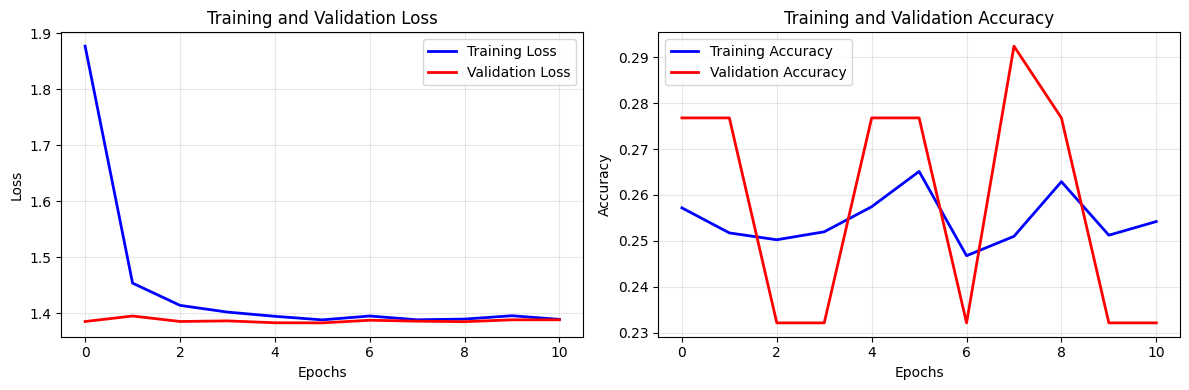

In [55]:
import matplotlib.pyplot as plt

# Afficher les courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Afficher le rapport de classification avec 4 chiffres après la virgule
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les vraies labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Si les labels sont en one-hot encoding, les convertir en classes
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Afficher le rapport de classification avec 4 chiffres après la virgule
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(y_true, y_pred_classes,
                          target_names=class_names,
                          digits=4))


# Calculer et afficher les métriques globales
print("=" * 70)
print("MÉTRIQUES GLOBALES")
print("=" * 70)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step
RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

          Normal     0.3693    0.4567    0.4083       300
    Glioma Tumor     0.0000    0.0000    0.0000       288
Meningioma Tumor     0.2523    0.7354    0.3757       257
 Pituitary Tumor     0.0000    0.0000    0.0000       275

        accuracy                         0.2911      1120
       macro avg     0.1554    0.2980    0.1960      1120
    weighted avg     0.1568    0.2911    0.1956      1120

MÉTRIQUES GLOBALES
Accuracy:  0.2911
Precision: 0.1568
Recall:    0.2911
F1-Score:  0.1956


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

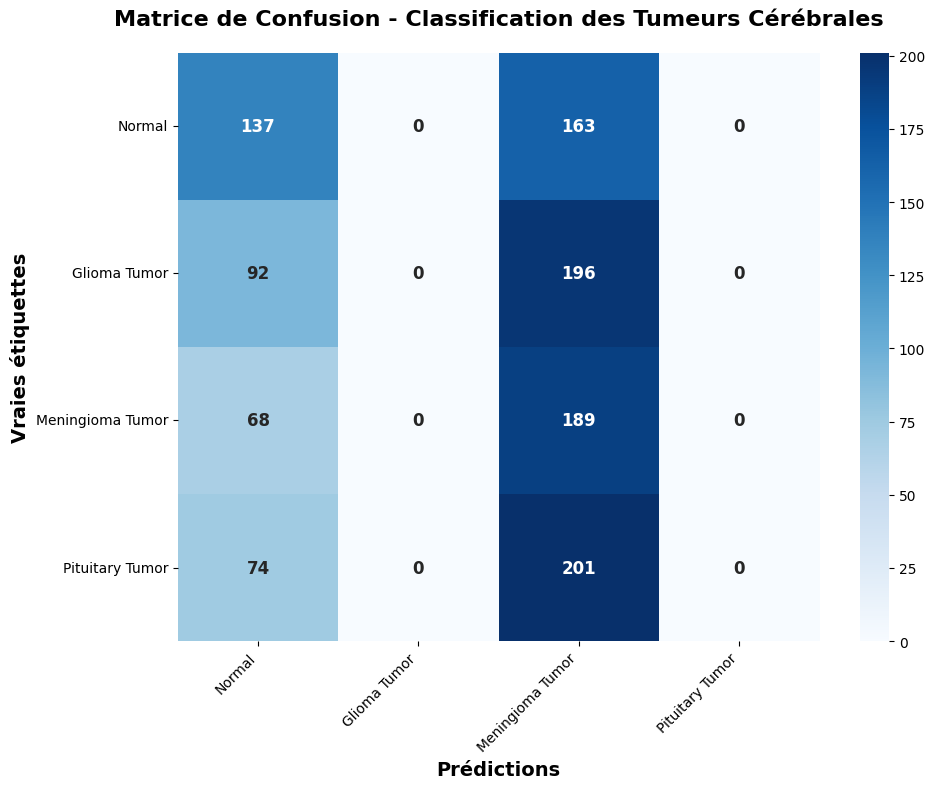

In [57]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Visualisation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matrice de Confusion - Classification des Tumeurs Cérébrales',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Vraies étiquettes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Préparation du modéle InceptionV3


In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger InceptionV3
base_model = InceptionV3(
    include_top=False,
    input_shape=(299, 299, 3),  # InceptionV3 utilise 299x299
    weights='imagenet'
)

# Dégeler les 50 dernières couches
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
def resize_for_inception(x, y):
    x = tf.image.resize(x, (299, 299))
    return x, y

train_dataset_incep = train_dataset.map(resize_for_inception)
val_dataset_incep = val_dataset.map(resize_for_inception)


# Définir les callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_inceptionV3.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Entraîner le modèle
history = model.fit(
    train_dataset_incep,
    epochs=50,
    validation_data=val_dataset_incep,
    callbacks=callbacks,
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_inceptionV3.keras")


Epoch 1/50
    126/Unknown 32s 165ms/step - accuracy: 0.4737 - loss: 1.5166

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.55134, saving model to best_inceptionV3.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - accuracy: 0.4744 - loss: 1.5144 - val_accuracy: 0.5513 - val_loss: 0.9969
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7571 - loss: 0.6230
Epoch 2: val_accuracy improved from 0.55134 to 0.72321, saving model to best_inceptionV3.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.7572 - loss: 0.6228 - val_accuracy: 0.7232 - val_loss: 0.6753
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8533 - loss: 0.3871
Epoch 3: val_accuracy improved from 0.72321 to 0.76786, saving model to best_inceptionV3.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.8535 - loss: 0.3868 - val_accuracy: 0.7679 - val_loss: 0.6047
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9351 - loss: 0.1801
Epoch 4: val_accuracy improved from 0.76786 to 0.82366, saving model to best_inceptionV3.kera

In [21]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

model = load_model('best_inceptionV3.keras')

# Afficher le résumé pour vérifier le chargement
# model.summary()

print("Modèle rechargé avec succès!")

Modèle rechargé avec succès!


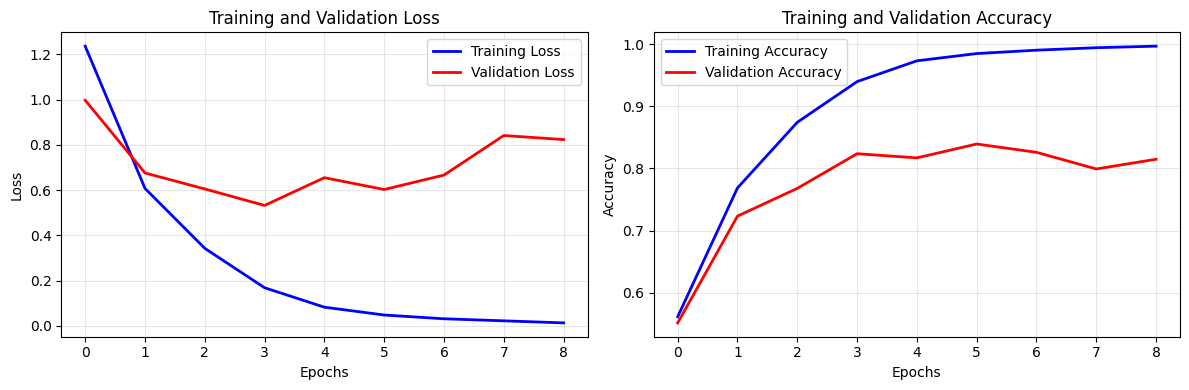

In [22]:
import matplotlib.pyplot as plt

# Afficher les courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Définir la taille d'entrée pour InceptionV3
IMG_SIZE = (299, 299)

# Charger le dataset de test avec la bonne taille
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset/test',
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False
)

# Appliquer le préprocessing spécifique à InceptionV3
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

# Prédire les classes
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les vraies labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Si les labels sont en one-hot encoding, les convertir en classes
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Afficher le rapport de classification
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)
print(classification_report(y_true, y_pred_classes,
                            target_names=class_names,
                            digits=4))

# Calculer et afficher les métriques globales
print("=" * 70)
print("MÉTRIQUES GLOBALES")
print("=" * 70)

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


Found 800 files belonging to 4 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
RAPPORT DE CLASSIFICATION DÉTAILLÉ
                  precision    recall  f1-score   support

          Normal     0.8505    0.9100    0.8792       200
    Glioma Tumor     0.6914    0.8850    0.7763       200
Meningioma Tumor     0.8025    0.6300    0.7059       200
 Pituitary Tumor     0.8902    0.7700    0.8257       200

        accuracy                         0.7987       800
       macro avg     0.8086    0.7987    0.7968       800
    weighted avg     0.8086    0.7987    0.7968       800

MÉTRIQUES GLOBALES
Accuracy:  0.7987
Precision: 0.8086
Recall:    0.7987
F1-Score:  0.7968


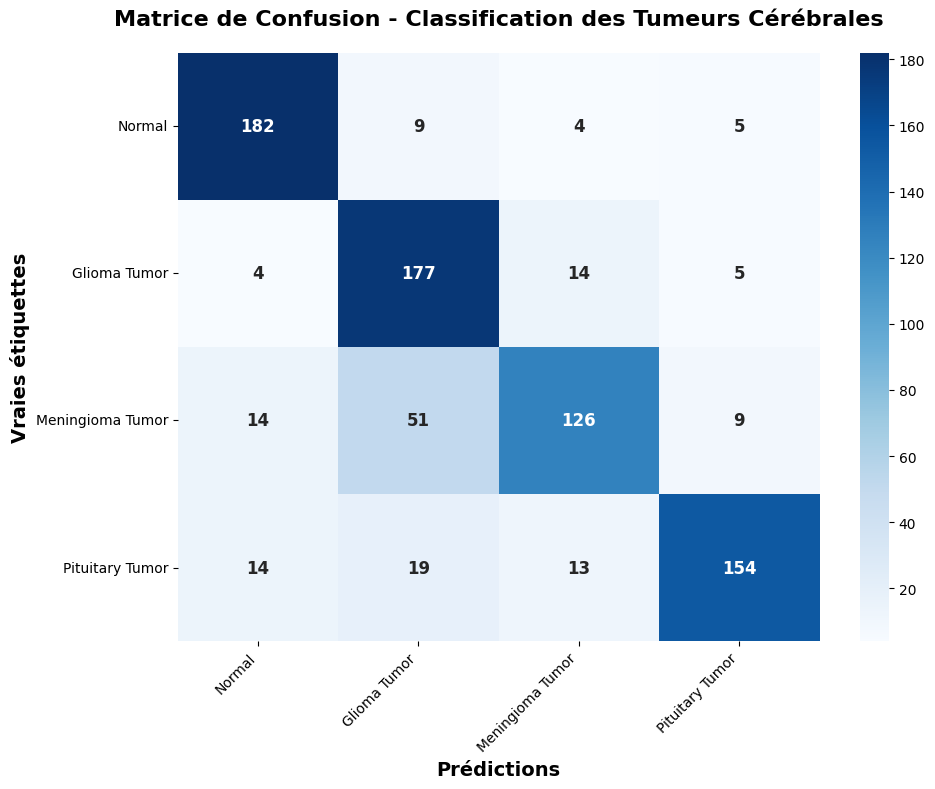

In [34]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définir les noms des classes
class_names = ["Normal", "Glioma Tumor", "Meningioma Tumor", "Pituitary Tumor"]

# Visualisation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matrice de Confusion - Classification des Tumeurs Cérébrales',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=14, fontweight='bold')
plt.ylabel('Vraies étiquettes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Modele et train (VGG19 sans imagenet)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger un modèle pré-entraîné (VGG19)
base_model = VGG19(include_top=False, input_shape=(224,224,3), weights=None)

# Dégeler partiellement le modèle (ex : les 10 dernières couches)
for layer in base_model.layers:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Changé à 4 pour vos 4 classes

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
# Callbacks
callbacks = [
    # EarlyStopping : arrêter l'entraînement quand la performance ne s'améliore plus
    EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=3,                   # Nombre d'époques sans amélioration avant arrêt
        restore_best_weights=True,    # Restaurer les poids du meilleur modèle
        verbose=1
    ),

    # ModelCheckpoint : sauvegarder le meilleur modèle
    ModelCheckpoint(
        filepath='best_modelVGG19.keras',  # Nom du fichier de sauvegarde
        monitor='val_accuracy',            # Surveiller la précision de validation
        save_best_only=True,               # Sauvegarder seulement le meilleur modèle
        mode='max',                        # Mode 'max' car on veut maximiser l'accuracy
        verbose=1
    )
]

# Entraîner le modèle
history = model.fit(
    train_dataset,                    # Dataset d'entraînement
    epochs=50,                        # Maximum d'époques
    validation_data=val_dataset,      # Dataset de validation
    callbacks=callbacks,              # Callbacks définis ci-dessus
    verbose=1
)

print("Entraînement terminé!")
print(f"Meilleur modèle sauvegardé sous: best_modelVGG19.keras")

# XAI

## 📦 Installation des dépendances nécessaires
## 🧠 Importation des librairies

In [ ]:
#Exploiter différentes méthodes de XAI -- se référer aux liens Github donnés dans le support de cours
# =====================================================
# 📦 Installation des dépendances nécessaires
# =====================================================
!pip install -q lime shap opencv-python-headless #tensorflow==2.15.0

# =====================================================
# 🧠 Importation des librairies
# =====================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 🔹 1️⃣ Chargement du modèle et de l'image

✅ Modèle chargé : /content/best_modelVGG19.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Classe prédite : 2 | Confiance : 1.0000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


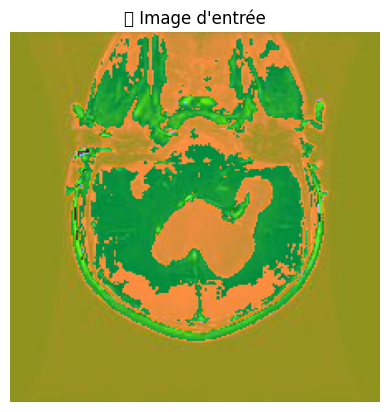

In [ ]:
# =====================================================
# 🔹 1️⃣ Chargement du modèle et de l'image
# =====================================================
model_path = '/content/best_modelVGG19.keras'
image_path = '/content/dataset/train/glioma_tumor/G_105_VF__8.jpg'

# Charger le modèle
model = load_model(model_path)
print("✅ Modèle chargé :", model_path)

# Charger et prétraiter l'image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

# Prédiction
preds = model.predict(img_preprocessed)
predicted_class = np.argmax(preds)
confidence = np.max(preds)
print(f"✅ Classe prédite : {predicted_class} | Confiance : {confidence:.4f}")
plt.imshow(img_array.astype('uint8'))
plt.title("🖼️ Image d'entrée")
plt.axis('off')
plt.show()

## 🔹 2️⃣ LIME

In [ ]:
# =====================================================
# 🔹 2️⃣ LIME (Version 1 avec preprocess)
# =====================================================
print("\n🔍 Application de LIME ...")

explainer_lime = lime_image.LimeImageExplainer()
explanation = explainer_lime.explain_instance(
image=img_array.astype('double'),
classifier_fn=lambda x: model.predict(preprocess_input(x)),
top_labels=1,
hide_color=0,
num_samples=1000
)

# Extraire la carte d’explication
temp, mask = explanation.get_image_and_mask(
label=predicted_class,
positive_only=True,
num_features=5,
hide_rest=False
)
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("📍 LIME – Zones importantes")
plt.axis('off')
plt.show()


🔍 Application de LIME ...


TypeError: LimeImageExplainer.explain_instance() got an unexpected keyword argument 'verbose'


🔍 Application de LIME ...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

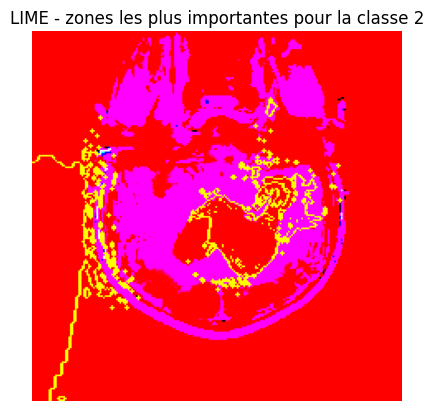

In [ ]:
# =====================================================
# 🔹 2️⃣ LIME (Version sans preprocess)
# =====================================================
print("\n🔍 Application de LIME ...")

# Create the LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Define prediction function
def predict_fn(images):
    images = np.array(images)
    preds = model.predict(images)
    return preds

# Explain one image
explanation = explainer.explain_instance(
    image=np.squeeze(img_preprocessed),   # image as (H, W, 3)
    classifier_fn=predict_fn,
    top_labels=1,                         # explain the top predicted class
    hide_color=0,                         # color for masked regions
    num_samples=1000                      # number of perturbations
)

# Get the explanation for the top predicted class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualize
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME - zones les plus importantes pour la classe {top_label}")
plt.axis("off")
plt.show()


## 🔹 3️⃣ SHAP


🔍 Application de SHAP ...


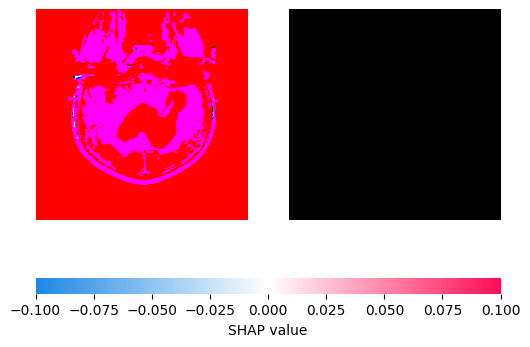

In [ ]:
# =====================================================
# 🔹 3️⃣ SHAP
# =====================================================
print("\n🔍 Application de SHAP ...")

# Sélection d’un petit échantillon pour le fond de référence
# (ici on répète la même image plusieurs fois juste pour la démo)
background = np.repeat(img_preprocessed, 5, axis=0)

# Création de l'explainer basé sur les gradients
explainer_shap = shap.GradientExplainer(model, background)

# Calcul des valeurs SHAP pour l’image à expliquer
shap_values = explainer_shap.shap_values(img_preprocessed)

# Visualisation SHAP
shap.image_plot(shap_values, img_preprocessed)

## 🔹 4️⃣ Grad-CAM


🔍 Application de Grad-CAM ...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


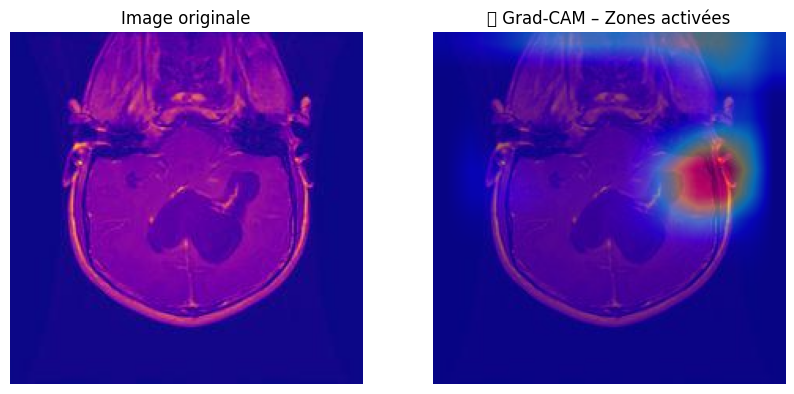


✅ Explications générées avec succès !


In [ ]:
# =====================================================
# 🔹 4️⃣ Grad-CAM
# =====================================================
print("\n🔍 Application de Grad-CAM ...")
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model(
  [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(predictions[0])
      class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  conv_outputs = conv_outputs[0]
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= tf.math.reduce_max(heatmap)
  return heatmap.numpy()

# Nom de la dernière couche convolutionnelle
last_conv_layer_name = "block5_conv4"

# Génération de la carte Grad-CAM
heatmap = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer_name)

# Superposition avec l'image originale
img_orig = cv2.imread(image_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

# Visualisation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.axis("off")
plt.subplot(1, 2, 2)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("🔥 Grad-CAM – Zones activées")
plt.axis("off")
plt.show()
print("\n✅ Explications générées avec succès !")


## 🔹 5️⃣ Grad-CAM++


🔍 Application de Grad-CAM++ ...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


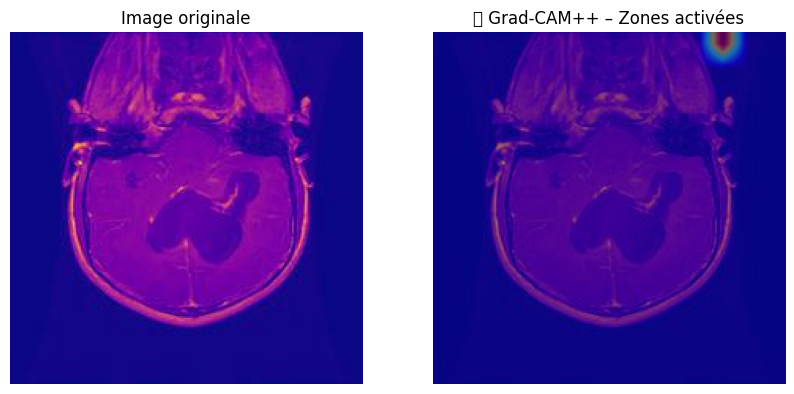


✅ Explications Grad-CAM++ générées avec succès !


In [ ]:
# =====================================================
# 🔹 5️⃣ Grad-CAM++
# =====================================================
print("\n🔍 Application de Grad-CAM++ ...")

def make_gradcampp_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]

            grads = tape3.gradient(class_channel, conv_outputs)
        grads2 = tape2.gradient(grads, conv_outputs)
    grads3 = tape1.gradient(grads2, conv_outputs)

    # Remove batch dimension
    conv_outputs = conv_outputs[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    # Compute weights (alpha_k)
    numerator = grads2
    denominator = 2.0 * grads2 + tf.reduce_sum(conv_outputs * grads3, axis=(0, 1), keepdims=True)
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    # Weights for each pixel
    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))

    # Weighted combination
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)

    # Normalize
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# Nom de la dernière couche convolutionnelle
last_conv_layer_name = "block5_conv4"

# Génération de la carte Grad-CAM++
heatmap = make_gradcampp_heatmap(img_preprocessed, model, last_conv_layer_name)

# Superposition avec l'image originale
img_orig = cv2.imread(image_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

# Visualisation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("🔥 Grad-CAM++ – Zones activées")
plt.axis("off")
plt.show()

print("\n✅ Explications Grad-CAM++ générées avec succès !")